In [679]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import sys
from time import time
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [680]:
# read .csv by pandas
file = 'heart.csv'
df = pd.read_csv(file)

# check the first 5 lines
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [681]:
# check missing values
df.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [735]:
# output in dataset is out target to trian,
# others are features
# transform them to numpy array to use StandardScaler
y = df.output.to_numpy()
x = df.drop('output', axis=1).to_numpy()

In [736]:
# scaler features' values by StandardScaler
scaler = StandardScaler().fit(x)
x = scaler.transform(x)

In [737]:
# split data by 20% of output
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

In [742]:
# convert two numpy arrays to pytorch dataset
def nparrays_to_dataset(x, y):
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    dataset = TensorDataset(x,y)
    return dataset

train_ds = nparrays_to_dataset(x_train, y_train)
test_ds = nparrays_to_dataset(x_test, y_test)

In [743]:
# convert dataset to dataloader
batch_size = 4
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False)

In [744]:
# model architecture
# nn.Module classes 4: 3 hidden layers
class BinaryNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size,32)
        self.l2 = nn.Linear(32, 16)
        self.l3 = nn.Linear(16, 8)
        self.out = nn.Linear(8, output_size)
        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = F.relu(x)
        x = self.out(x)
        return torch.sigmoid(x)  # scaling values between 0 and 1

In [745]:
# # model architecture
# # fully - connected neural network
# # nn.Module classes 3: 2 hidden layer
# class BinaryNetwork(nn.Module):
#     def __init__(self, input_size, output_size):
#         super().__init__()
#         self.l1 = nn.Linear(input_size, 32)
#         self.l2 = nn.Linear(32, 16)
#         self.out = nn.Linear(16, output_size)

#     def forward(self, x):
#         x = self.l1(x)
#         x = F.relu(x)
#         x = self.l2(x)
#         x = F.relu(x)
#         x = self.out(x)
#         return torch.sigmoid(x)  # scaling values between 0 and 1

In [746]:
# # model architecture
# # nn.Module classes 2: 1 hidden layer
# class BinaryNetwork(nn.Module):
#     def __init__(self, input_size, output_size):
#         super().__init__()
#         self.l1 = nn.Linear(input_size, 32)
#         self.out = nn.Linear(32, output_size)

#     def forward(self, x):
#         x = self.l1(x)
#         x = F.relu(x)
#         x = self.out(x)
#         return torch.sigmoid(x)  # scaling values between 0 and 1

In [747]:
# # model architecture
# # nn.Module classes 1 : logistic (0 hidden)
# class BinaryNetwork(nn.Module):
#     def __init__(self, input_size, output_size):
#         super().__init__()
#         self.l1 = nn.Linear(input_size, output_size)


#     def forward(self, x):
#         x = self.l1(x)
#         return torch.sigmoid(x)  # scaling values between 0 and 1

In [748]:
input_size = 13
output_size = 1
net = BinaryNetwork(input_size, output_size)
net

BinaryNetwork(
  (l1): Linear(in_features=13, out_features=32, bias=True)
  (l2): Linear(in_features=32, out_features=16, bias=True)
  (l3): Linear(in_features=16, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [749]:
loss_function = nn.BCELoss() # Binary Cross Entropy as Loss Function
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay = 5e-4) # Adam algorithm is usually the fatest 
num_epochs = 250

In [750]:
def hxt_train(net, train_dl, loss_function, optimizer, num_epochs, loss_list, acc_list):
    start = time()
    for epoch in range(num_epochs):
        epoch_loss = 0
        train_acc = 0
        for features, target in train_dl:
         # zero the parameter gradients
            optimizer.zero_grad()

             # forward + backward + optimize
            out = net(features)
            loss = loss_function(out, target.unsqueeze(1))
            res = torch.round(out).squeeze()
            right = res.eq(target)
            for i in range(right.numel()):
                if right[i] == True:
                    train_acc = train_acc + 1
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        acc = 100 * train_acc / len(train_dl) / train_dl.batch_size
        acc_list.append(acc)
        # append losses after training a time
        loss_list.append(epoch_loss)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}/{num_epochs}, Loss = {loss:.5f}, Acc = {acc:.5f}")
    end = time()
    print('Training time: %s Seconds'%(end-start))

In [751]:
loss_list = []
acc_list = []
hxt_train(net, train_dl, loss_function,optimizer, num_epochs, loss_list, acc_list)

Epoch: 0/250, Loss = 0.68869, Acc = 54.09836
Epoch: 10/250, Loss = 0.08443, Acc = 88.52459
Epoch: 20/250, Loss = 0.03997, Acc = 92.21311
Epoch: 30/250, Loss = 0.09211, Acc = 95.90164
Epoch: 40/250, Loss = 0.41965, Acc = 96.31148
Epoch: 50/250, Loss = 0.01653, Acc = 97.54098
Epoch: 60/250, Loss = 0.00026, Acc = 98.77049
Epoch: 70/250, Loss = 0.00006, Acc = 99.18033
Epoch: 80/250, Loss = 0.00001, Acc = 99.18033
Epoch: 90/250, Loss = 0.00000, Acc = 99.18033
Epoch: 100/250, Loss = 0.00423, Acc = 99.18033
Epoch: 110/250, Loss = 0.00053, Acc = 99.18033
Epoch: 120/250, Loss = 0.00305, Acc = 99.18033
Epoch: 130/250, Loss = 0.00332, Acc = 99.18033
Epoch: 140/250, Loss = 0.00001, Acc = 99.18033
Epoch: 150/250, Loss = 0.00399, Acc = 99.18033
Epoch: 160/250, Loss = 0.00001, Acc = 99.18033
Epoch: 170/250, Loss = 0.00287, Acc = 99.18033
Epoch: 180/250, Loss = 0.00002, Acc = 99.18033
Epoch: 190/250, Loss = 0.00856, Acc = 99.18033
Epoch: 200/250, Loss = 0.00010, Acc = 99.18033
Epoch: 210/250, Loss = 0

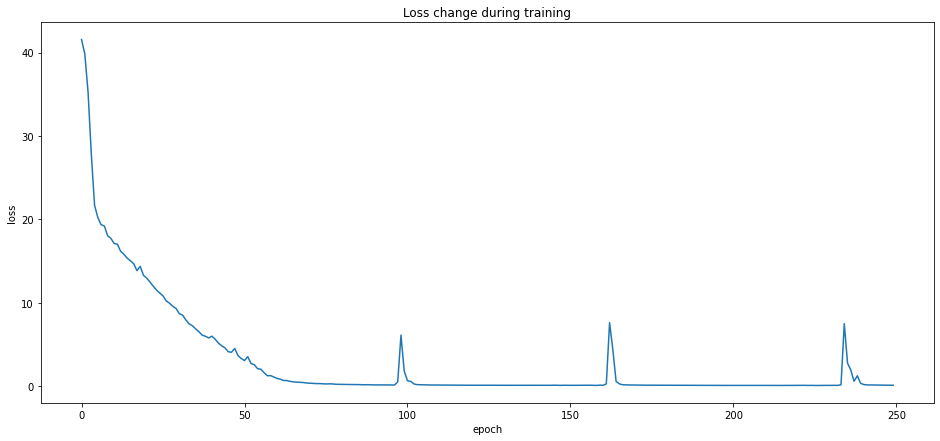

In [752]:
# set default figure size (more in length)
plt.rcParams['figure.figsize'] = (16, 7.0)

# plot training losses
graph_loss = sns.lineplot(x=[x for x in range(0, num_epochs)], y=loss_list)
graph_loss.set(title="Loss change during training", xlabel='epoch', ylabel='loss')
plt.show()

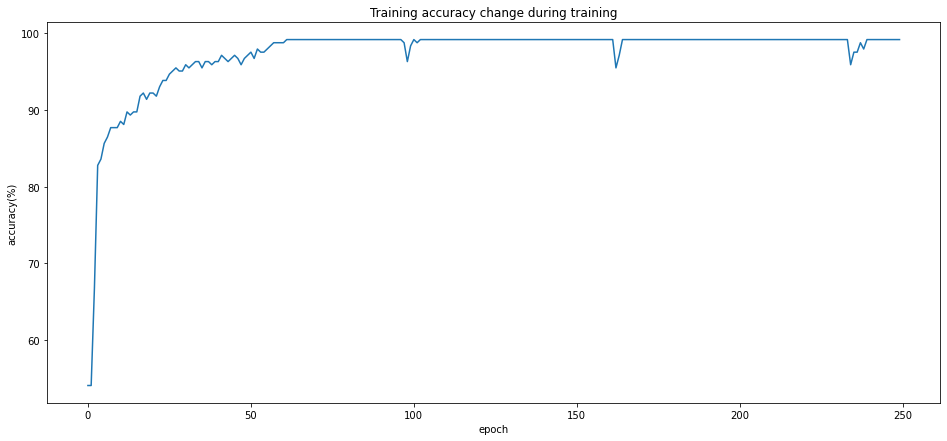

In [753]:
# plot training accuracy
graph_acc = sns.lineplot(x=[x for x in range(0, num_epochs)], y=acc_list)
graph_acc.set(title="Training accuracy change during training", xlabel='epoch', ylabel='accuracy(%)')
plt.show()

In [754]:
# evaluate the neural network (test)
y_pred_list = []
net.eval()
with torch.no_grad():
    for x, y in test_dl:
        output = net(x)
        y_pred = torch.round(output)
        y_pred_list.append(y_pred)

In [755]:
# convert predictions to a list of tensors with 1 dimention
y_pred_list = [y.squeeze() for y in y_pred_list]
# print measures of neural network prediction quality
print(classification_report(y_test, torch.hstack(y_pred_list)))

              precision    recall  f1-score   support

           0       0.72      0.75      0.74        28
           1       0.78      0.76      0.77        33

    accuracy                           0.75        61
   macro avg       0.75      0.75      0.75        61
weighted avg       0.76      0.75      0.75        61



In [ ]:
torch.save(model, 'net0.92.pt')